In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16 , ResNet50, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [16]:
#google drivea bağlanma
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#drivedan veriyi okuma
dataset_path = "/content/drive/MyDrive/fruits-360_dataset_100x100.zip"

In [18]:
import zipfile

zip_path = dataset_path
unzip_path = 'dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

In [19]:
ana_klasor = "/content/dataset/fruits-360_dataset_100x100/fruits-360"

In [20]:
import os
train_dir = os.path.join(ana_klasor, 'Training')
test_dir = os.path.join(ana_klasor, 'Test')

In [21]:
import os
import shutil
import random

validation_dir = os.path.join(ana_klasor, 'Validation')

# Training klasöründeki her bir sınıf için işlemi yap
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    # Eğer alt klasörse işlem yap
    if os.path.isdir(class_path):
        # Yeni validation klasörünü oluştur
        validation_class_path = os.path.join(validation_dir, class_name)
        os.makedirs(validation_class_path, exist_ok=True)

        # Sınıf içindeki tüm dosyaları al
        all_files = os.listdir(class_path)

        # Eğitim verisinin %20'sini doğrulama için seç
        num_files_to_move = int(0.2 * len(all_files))
        files_to_move = random.sample(all_files, num_files_to_move)

        # Dosyaları validation klasörüne taşı
        for file_name in files_to_move:
            source = os.path.join(class_path, file_name)
            destination = os.path.join(validation_class_path, file_name)
            shutil.move(source, destination)

        print(f'{num_files_to_move} dosya {class_name} sınıfından validation klasörüne taşındı.')

print("Validation set başarıyla oluşturuldu!")


78 dosya Cucumber Ripe 1 sınıfından validation klasörüne taşındı.
90 dosya Potato Sweet 1 sınıfından validation klasörüne taşındı.
48 dosya Zucchini dark 1 sınıfından validation klasörüne taşındı.
96 dosya Apple Golden 1 sınıfından validation klasörüne taşındı.
98 dosya Pitahaya Red 1 sınıfından validation klasörüne taşındı.
90 dosya Potato Red 1 sınıfından validation klasörüne taşındı.
48 dosya Eggplant long 1 sınıfından validation klasörüne taşındı.
98 dosya Raspberry 1 sınıfından validation klasörüne taşındı.
98 dosya Kaki 1 sınıfından validation klasörüne taşındı.
96 dosya Nectarine Flat 1 sınıfından validation klasörüne taşındı.
93 dosya Cucumber Ripe 2 sınıfından validation klasörüne taşındı.
98 dosya Mango 1 sınıfından validation klasörüne taşındı.
98 dosya Clementine 1 sınıfından validation klasörüne taşındı.
93 dosya Eggplant 1 sınıfından validation klasörüne taşındı.
98 dosya Strawberry 1 sınıfından validation klasörüne taşındı.
98 dosya Tangelo 1 sınıfından validation klasör

In [22]:
conv_base = {
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3)),
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3)),
    'MobileNet': MobileNet(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
}

<ipython-input-22-932fbf5c8569>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  'MobileNet': MobileNet(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


In [23]:
conv_base["VGG16"].summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizasyon
)
batch_size = 20

def extract_features(model_name, model, directory, sample_count):
    """
    Özellik çıkarma fonksiyonu. Her model için ayrı uygulanır.
    """
    features_shape = model.output_shape[1:]  # Modelin konvolüsyonel taban çıkış boyutu
    features = np.zeros(shape=(sample_count, *features_shape))
    labels = np.zeros(shape=(sample_count, 141))  # 141 sınıf için one-hot etiketler

    generator = datagen.flow_from_directory(
        directory,
        target_size=(100, 100),
        batch_size=batch_size,
        class_mode='categorical'  # 141 sınıfa uygun
    )

    i = 0
    for inputs_batch, labels_batch in generator:
        # Mevcut batch'in gerçek boyutunu belirle
        current_batch_size = inputs_batch.shape[0]

        features_batch = model.predict(inputs_batch)
        features[i * batch_size: i * batch_size + current_batch_size] = features_batch
        labels[i * batch_size: i * batch_size + current_batch_size] = labels_batch

        i += 1
        if i * batch_size >= sample_count:
            break

    print(f"Features extracted for {model_name}: {features.shape}")
    return features, labels

# 3. Tüm Modeller İçin Özellik Çıkarma
train_sample_count = 2000  # Örnek eğitim veri sayısı
val_sample_count=1000
test_sample_count = 1000  # Örnek doğrulama veri sayısı

all_features = {}
all_labels = {}

for model_name, model in conv_base.items():
    print(f"Processing model: {model_name}")
    all_features[model_name] = {}
    all_labels[model_name] = {}

    # Eğitim verisi için özellik çıkarımı
    all_features[model_name]['train_features'], all_labels[model_name]['train_labels'] = extract_features(
        model_name, model, train_dir, train_sample_count
    )

    all_features[model_name]['validation_features'], all_labels[model_name]['validation_labels'] = extract_features(
        model_name, model, validation_dir, val_sample_count
    )

    # Doğrulama verisi için özellik çıkarımı
    all_features[model_name]['test_features'], all_labels[model_name]['test_labels'] = extract_features(
        model_name, model, test_dir, test_sample_count
    )


Processing model: VGG16
Found 56432 images belonging to 141 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━

In [25]:
# Dinamik input_shape belirleme
model_output_shapes = {}
for model_name, model in conv_base.items():
    # Modelin çıkış boyutunu belirle
    output_shape = model.output_shape[1:]  # (height, width, channels)
    model_output_shapes[model_name] = np.prod(output_shape)  # height * width * channels

print(model_output_shapes)

{'VGG16': 4608, 'ResNet50': 32768, 'MobileNet': 9216}


In [26]:
model_hyperparams = {
    'VGG16': {
        'patience': 1.5,
        'restore_best_weights': True,
        'dropout_rate': 0.5,
        'learning_rate': 1e-5
    },
    'ResNet50': {
        'patience': 2,
        'restore_best_weights': True,
        'dropout_rate': 0.4,
        'learning_rate': 1.5e-4
    },
    'MobileNet': {
        'patience': 1,
        'restore_best_weights': True,
        'dropout_rate': 0.6,
        'learning_rate': 1e-5
    }
}


In [27]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

history_dict = {}

for model_name in conv_base.keys():
    print(f"Training classifier for {model_name}")

    # Özelliklere ve etiketlere erişim
    train_features = all_features[model_name]['train_features']
    test_features = all_features[model_name]['test_features']
    validation_features = all_features[model_name]['validation_features']

    validation_labels = all_labels[model_name]['validation_labels']
    train_labels = all_labels[model_name]['train_labels']
    test_labels = all_labels[model_name]['test_labels']

    # Modelin çıkış boyutunu al
    input_shape = model_output_shapes[model_name]

    # Özellikleri yeniden şekillendir (Flatten)
    train_features = np.reshape(train_features, (train_features.shape[0], input_shape))  # (örnek_sayısı, özellik_boyutu)
    validation_features = np.reshape(validation_features, (validation_features.shape[0], input_shape))  # (örnek_sayısı, özellik_boyutu)
    test_features = np.reshape(test_features, (test_features.shape[0], input_shape))  # (örnek_sayısı, özellik_boyutu)

    # Model parametrelerini alın
    params = model_hyperparams[model_name]
    patience = params['patience']
    restore_best_weights = params['restore_best_weights']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']

    # Sınıflandırıcı modeli oluştur
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(input_shape,)),
        Dropout(dropout_rate),
        Dense(141, activation='softmax')  # 141 sınıf için
    ])

    # Modeli derle
    model.compile(
        optimizer=RMSprop(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping ve model checkpoint callback'lerini tanımla
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=restore_best_weights)
    checkpoint_path = f"first_model_{model_name}.keras"
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

    # Modeli eğit
    history = model.fit(
        train_features,
        train_labels,
        epochs=30,
        batch_size=20,
        validation_data=(validation_features, validation_labels),
        callbacks=[early_stopping, model_checkpoint]
    )

    # Eğitim geçmişini kaydet
    history_dict[model_name] = history

    print(f"Best model for {model_name} saved at {checkpoint_path}")


Training classifier for VGG16
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.0078 - loss: 5.4310 - val_accuracy: 0.0110 - val_loss: 4.9454
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0140 - loss: 5.1082 - val_accuracy: 0.0350 - val_loss: 4.7893
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0267 - loss: 4.8935 - val_accuracy: 0.0750 - val_loss: 4.6669
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0398 - loss: 4.7312 - val_accuracy: 0.1310 - val_loss: 4.5604
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0682 - loss: 4.6146 - val_accuracy: 0.1640 - val_loss: 4.4612
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0876 - loss: 4.4836 - val_accuracy: 0.2010 - val_loss: 4.3678
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1116 - loss: 4.3795 - val_accuracy: 0.2270 - val_loss: 4.2755
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1583 - 

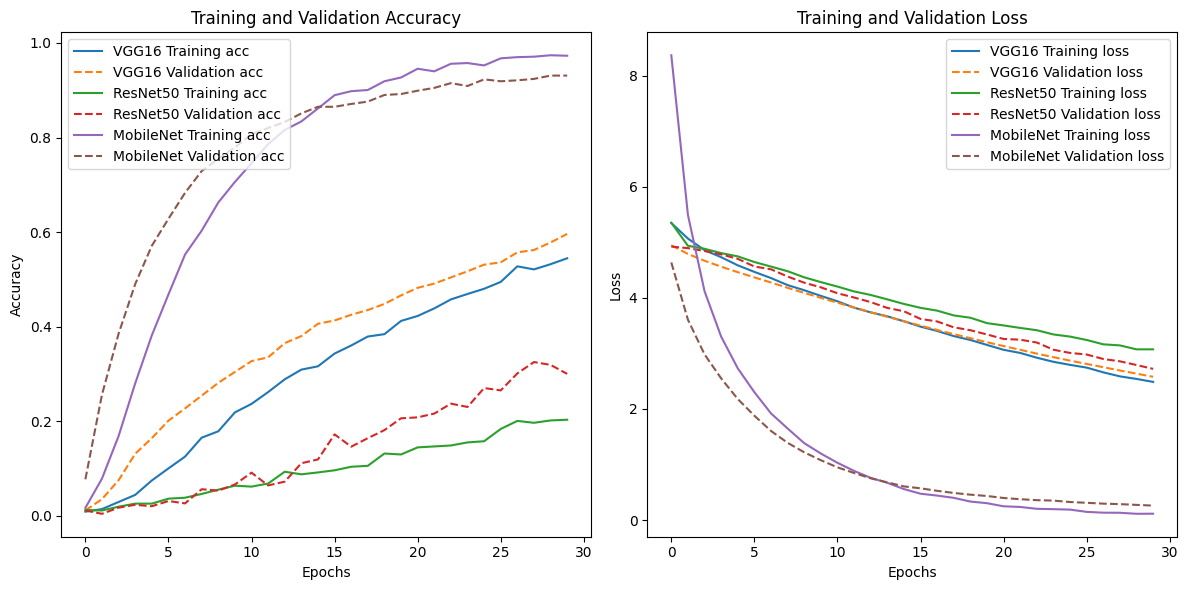

In [28]:
plt.figure(figsize=(12, 6))

for model_name, history in history_dict.items():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    # Eğitim ve doğrulama doğruluğu
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label=f'{model_name} Training acc')
    plt.plot(epochs, val_acc, '--', label=f'{model_name} Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Eğitim ve doğrulama kaybı
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label=f'{model_name} Training loss')
    plt.plot(epochs, val_loss, '--', label=f'{model_name} Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

In [29]:
from keras.applications import VGG16, ResNet50, MobileNet
from keras import models, layers
from keras.layers import GlobalAveragePooling2D, Conv2D

# List to store the models
model_list = []

# Loop over the dictionary to add each model to the Sequential model
for model_name, base_model in conv_base.items():
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(141, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Add the model to the list
    model_list.append(model)

    # Print model summary
    print(f"Model summary for {model_name}:")
    model.summary()
    print("\n")

    # Print the number of trainable weights before freezing the conv base
    print(f"This is the number of trainable weights before freezing the conv base for {model_name}:")
    print(len(model.trainable_weights))
    print("\n")


Model summary for VGG16:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 15,384,525 (58.69 MB)

 Trainable params: 15,384,525 (58.69 MB)

 Non-trainable params: 0 (0.00 B)



This is the number of trainable weights before freezing the conv base for VGG16:
30


Model summary for ResNet50:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 106, 106, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 50, 50, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 50, 50, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 50, 50, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 52, 52, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 25, 25, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 25, 25, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 25, 25, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 25, 25, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 25, 25, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,830,413 (98.54 MB)

 Trainable params: 25,777,293 (98.33 MB)

 Non-trainable params: 53,120 (207.50 KB)



This is the number of trainable weights before freezing the conv base for ResNet50:
216


Model summary for MobileNet:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 50, 50, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 50, 50, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 50, 50, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 50, 50, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 50, 50, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 50, 50, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 51, 51, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 25, 25, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 25, 25, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 25, 25, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 25, 25, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 25, 25, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 25, 25, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 25, 25, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,422,989 (16.87 MB)

 Trainable params: 4,401,101 (16.79 MB)

 Non-trainable params: 21,888 (85.50 KB)



This is the number of trainable weights before freezing the conv base for MobileNet:
85




In [30]:
conv_base["VGG16"].trainable = False

In [31]:
conv_base["ResNet50"].trainable = False

In [32]:
conv_base["MobileNet"].trainable = False

In [33]:
for model in model_list:
      print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4
This is the number of trainable weights after freezing the conv base: 4
This is the number of trainable weights after freezing the conv base: 4


In [34]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),  # Modelin beklediği boyut
    batch_size=20,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(100, 100),
    batch_size=20,
    class_mode='categorical')


Found 56432 images belonging to 141 classes.
Found 25244 images belonging to 141 classes.


In [36]:
# Eğitim sonuçlarını saklamak için bir sözlük
history_dict2 = {}

# Modeller için döngü
for model in model_list:
    if(model.name == "functional_6"):
      model_name = "VGG16"
    elif(model.name == "functional_7"):
      model_name = "ResNet50"
    else:
      model_name = "MobileNet"

    print(f"Training classifier for {model_name} 2")

    # Modeli derle
    model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(learning_rate=2e-5),
        metrics=['accuracy']
    )

    # Modeli eğit
    history = model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1
    )

    # Eğitim geçmişini kaydet
    history_dict2[model_name] = history
    model.save(f"second_model_{model_name}.h5")

    print(f"Training 2 for {model_name} completed.")


Training classifier for VGG16 2
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.0083 - loss: 5.0543 - val_accuracy: 0.0130 - val_loss: 4.9143
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.0118 - loss: 4.9802 - val_accuracy: 0.0160 - val_loss: 4.8789
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.0117 - loss: 4.9482 - val_accuracy: 0.0350 - val_loss: 4.8464
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.0161 - loss: 4.9029 - val_accuracy: 0.0400 - val_loss: 4.8117
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.0201 - loss: 4.8941 - val_accuracy: 0.0340 - val_loss: 4.7986
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.0221 - loss: 4.8912 - val_accuracy: 0.0560 - val_loss: 4.7514
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.0264 - loss: 4.8247 - val_accuracy: 0.0420 - val_loss: 4.7525
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accurac

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1089 - loss: 4.4336 - val_accuracy: 0.1490 - val_loss: 4.2957
Epoch 28/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.1197 - loss: 4.3690 - val_accuracy: 0.1700 - val_loss: 4.2597
Epoch 29/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1236 - loss: 4.3842 - val_accuracy: 0.1290 - val_loss: 4.3247
Epoch 30/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.1032 - loss: 4.4063 - val_accuracy: 0.1840 - val_loss: 4.2187


Training 2 for VGG16 completed.
Training classifier for ResNet50 2
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.0044 - loss: 5.3303 - val_accuracy: 0.0100 - val_loss: 4.9703
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.0102 - loss: 5.1324 - val_accuracy: 0.0140 - val_loss: 4.9306
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.0115 - loss: 5.0583 - val_accuracy: 0.0170 - val_loss: 4.9291
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.0119 - loss: 5.0555 - val_accuracy: 0.0210 - val_loss: 4.9133
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.0120 - loss: 4.9860 - val_accuracy: 0.0140 - val_loss: 4.9034
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.0097 - loss: 4.9646 - val_accuracy: 0.0120 - val_loss: 4.8976
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.0089 - loss: 4.9577 - val_accuracy: 0.0280 - val_loss: 4.8879
Epoch 8/30
100/100 ━━━━━━━━━

Training 2 for ResNet50 completed.
Training classifier for MobileNet 2
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.0147 - loss: 6.8085 - val_accuracy: 0.0150 - val_loss: 5.1801
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.0184 - loss: 5.9619 - val_accuracy: 0.0650 - val_loss: 4.6059
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.0234 - loss: 5.4141 - val_accuracy: 0.1070 - val_loss: 4.3140
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.0538 - loss: 4.9771 - val_accuracy: 0.1750 - val_loss: 3.9624
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.0813 - loss: 4.6933 - val_accuracy: 0.2320 - val_loss: 3.7226
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.0975 - loss: 4.3938 - val_accuracy: 0.2410 - val_loss: 3.5793
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1281 - loss: 4.1383 - val_accuracy: 0.3570 - val_loss: 3.2560
Epoch 8/30
100/100 ━━━━━━

Training 2 for MobileNet completed.


In [37]:
conv_base["VGG16"].summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

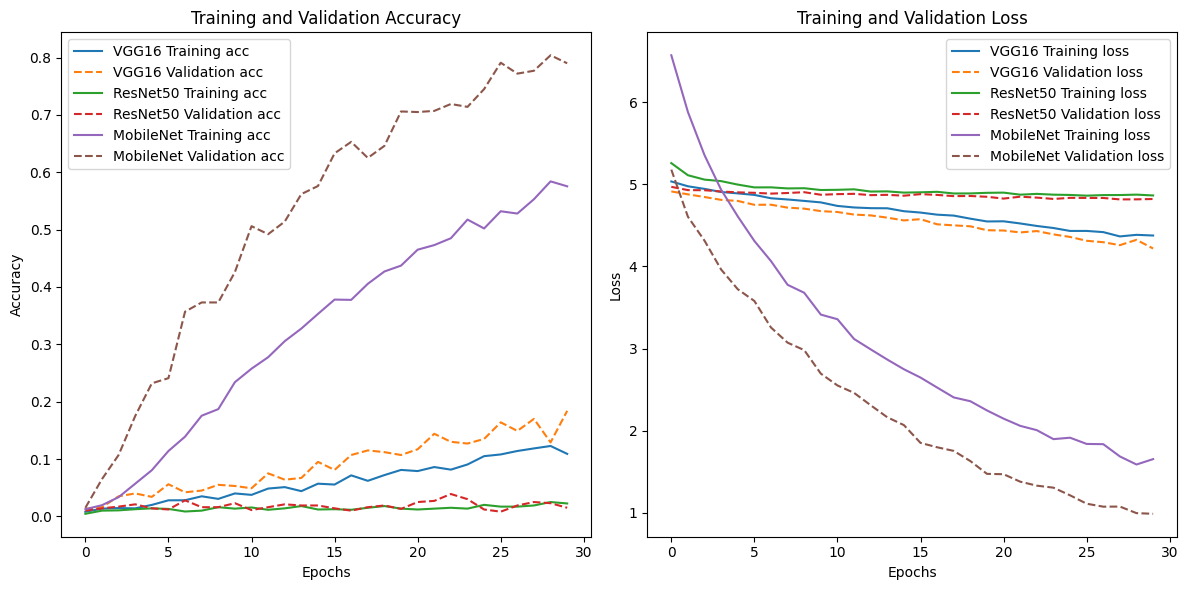

In [38]:
plt.figure(figsize=(12, 6))

for model_name, history in history_dict2.items():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    # Eğitim ve doğrulama doğruluğu
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label=f'{model_name} Training acc')
    plt.plot(epochs, val_acc, '--', label=f'{model_name} Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Eğitim ve doğrulama kaybı
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label=f'{model_name} Training loss')
    plt.plot(epochs, val_loss, '--', label=f'{model_name} Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

In [41]:
def set_trainable_layers(model, start_layer_name):
    """
    Belirli bir katmandan itibaren tüm katmanları eğitilebilir hale getirir.

    Args:
    model: Önceden eğitilmiş bir model
    start_layer_name: Eğitilebilir katmanların başlayacağı katman adı (str)
    """
    set_trainable = False
    for layer in model.layers:
        if layer.name == start_layer_name:
            set_trainable = True
        layer.trainable = set_trainable
    print(f"Eğitilebilir katmanlar ayarlandı: {start_layer_name} katmanından itibaren.")

# Her model için uygun başlangıç katmanlarını belirleyin
start_layers = {
    'VGG16': 'block5_conv1',
    'ResNet50': 'conv5_block1_out',
    'MobileNet': 'conv_dw_13_bn'
}

for model_name, model in conv_base.items():
    model.trainable = True  # Tüm katmanları dondurmayı iptal edin
    set_trainable_layers(model, start_layers[model_name])
    print(f"{model_name} modeli için güncelleme tamamlandı.")

Eğitilebilir katmanlar ayarlandı: block5_conv1 katmanından itibaren.
VGG16 modeli için güncelleme tamamlandı.
Eğitilebilir katmanlar ayarlandı: conv5_block1_out katmanından itibaren.
ResNet50 modeli için güncelleme tamamlandı.
Eğitilebilir katmanlar ayarlandı: conv_dw_13_bn katmanından itibaren.
MobileNet modeli için güncelleme tamamlandı.


In [42]:
conv_base["VGG16"].summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [44]:
# Eğitim parametreleri
epochs = 100
steps_per_epoch = 100
validation_steps = 50
learning_rate = 1e-5

trained_histories = {}  # Eğitim geçmişlerini saklamak için bir dict

# Her model için başlangıç katmanı isimleri

# Her model için eğitim döngüsü
for model in model_list:
    if(model.name == "functional_6"):
      model_name = "VGG16"
    elif(model.name == "functional_7"):
      model_name = "ResNet50"
    else:
      model_name = "MobileNet"
    print(f"Training model: {model_name}")

    # Modeli derle
    model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    # Modeli eğit
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps
    )

    # Eğitim geçmişini sakla
    trained_histories[model_name] = history
    print(f"Saving model: {model_name}")
    model.save(f'{model_name}_ft.h5')

Training model: VGG16
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.5586 - loss: 1.6218 - val_accuracy: 0.8240 - val_loss: 0.8510
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.5501 - loss: 1.6138 - val_accuracy: 0.8420 - val_loss: 0.7309
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.5602 - loss: 1.5474 - val_accuracy: 0.8380 - val_loss: 0.7984
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5822 - loss: 1.5486 - val_accuracy: 0.8570 - val_loss: 0.7260
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5839 - loss: 1.4362 - val_accuracy: 0.8630 - val_loss: 0.6463
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6035 - loss: 1.3992 - val_accuracy: 0.8830 - val_loss: 0.5848
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5985 - loss: 1.4284 - val_accuracy: 0.8740 - val_loss: 0.6451
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0

Saving model: VGG16
Training model: ResNet50
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.0933 - loss: 3.9117 - val_accuracy: 0.2120 - val_loss: 3.3506
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.1093 - loss: 3.8580 - val_accuracy: 0.1900 - val_loss: 3.3562
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.1168 - loss: 3.8182 - val_accuracy: 0.2060 - val_loss: 3.4292
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1244 - loss: 3.8403 - val_accuracy: 0.2280 - val_loss: 3.2086
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1203 - loss: 3.8007 - val_accuracy: 0.2270 - val_loss: 3.2087
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1407 - loss: 3.6635 - val_accuracy: 0.2630 - val_loss: 3.1317
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1320 - loss: 3.6212 - val_accuracy: 0.1380 - val_loss: 3.5211
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 

Saving model: ResNet50
Training model: MobileNet
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.6124 - loss: 1.4461 - val_accuracy: 0.8660 - val_loss: 0.6341
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.6288 - loss: 1.4102 - val_accuracy: 0.8550 - val_loss: 0.6552
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6362 - loss: 1.3381 - val_accuracy: 0.8670 - val_loss: 0.6405
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6235 - loss: 1.3697 - val_accuracy: 0.8650 - val_loss: 0.6136
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.6155 - loss: 1.4258 - val_accuracy: 0.8720 - val_loss: 0.5984
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6354 - loss: 1.3915 - val_accuracy: 0.8850 - val_loss: 0.5778
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6720 - loss: 1.2692 - val_accuracy: 0.8880 - val_loss: 0.5335
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━

Saving model: MobileNet


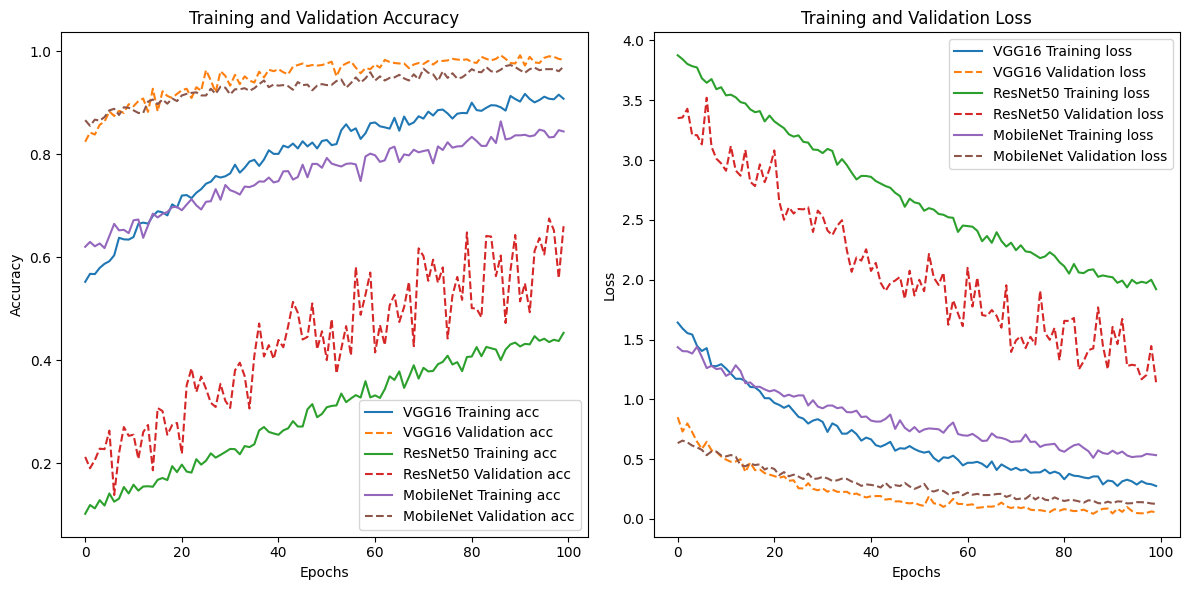

In [45]:
plt.figure(figsize=(12, 6))

for model_name, history in trained_histories.items():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    # Eğitim ve doğrulama doğruluğu
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label=f'{model_name} Training acc')
    plt.plot(epochs, val_acc, '--', label=f'{model_name} Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Eğitim ve doğrulama kaybı
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label=f'{model_name} Training loss')
    plt.plot(epochs, val_loss, '--', label=f'{model_name} Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

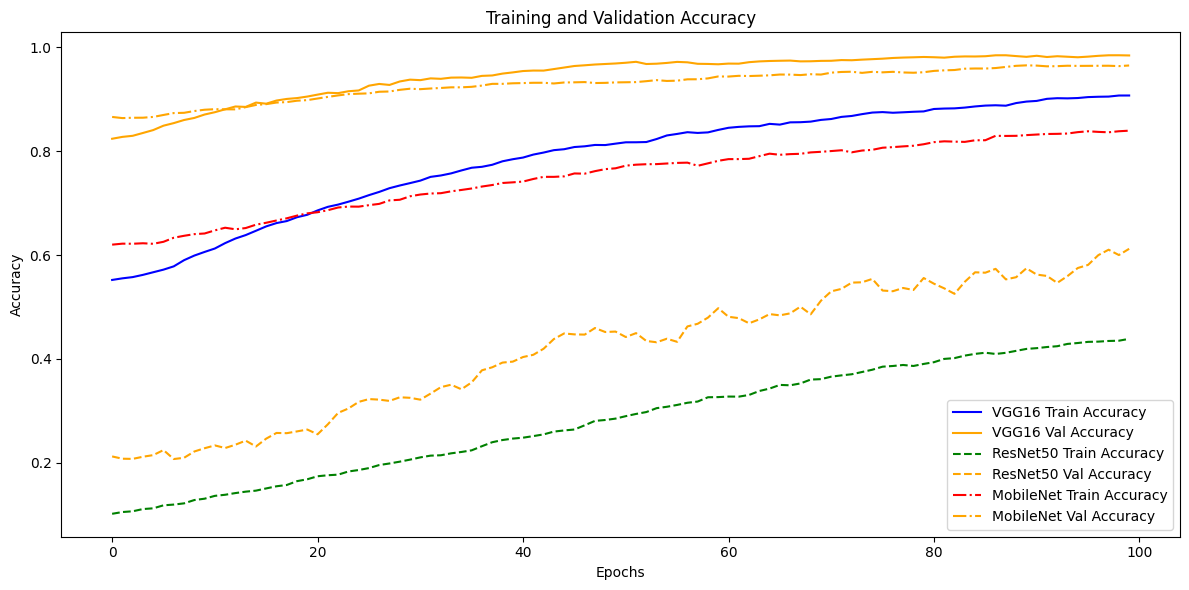

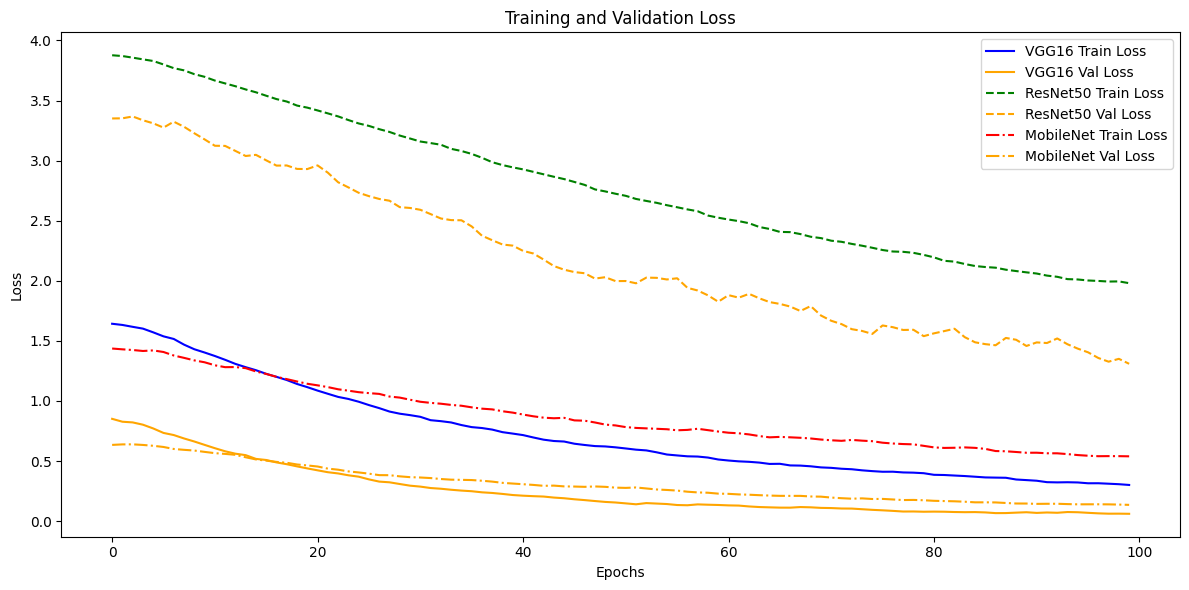

In [46]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Model renkleri (her model için farklı bir renk)
model_colors = ['b', 'g', 'r', 'c', 'm', 'y']
train_color = 'b'  # Eğitim için mavi renk
val_color = 'orange'  # Doğrulama için turuncu renk
linestyles = ['-', '--', '-.', ':']

# İlk grafik için doğruluk (accuracy)
plt.figure(figsize=(12, 6))

for idx, (model_name, history) in enumerate(trained_histories.items()):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    # Eğitim doğruluğu (train accuracy)
    plt.plot(epochs, smooth_curve(acc), linestyle=linestyles[idx % len(linestyles)], color=model_colors[idx % len(model_colors)], label=f'{model_name} Train Accuracy')

    # Doğrulama doğruluğu (validation accuracy)
    plt.plot(epochs, smooth_curve(val_acc), linestyle=linestyles[idx % len(linestyles)], color=val_color, label=f'{model_name} Val Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

# İkinci grafik için kayıp (loss)
plt.figure(figsize=(12, 6))

for idx, (model_name, history) in enumerate(trained_histories.items()):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    # Eğitim kaybı (train loss)
    plt.plot(epochs, smooth_curve(loss), linestyle=linestyles[idx % len(linestyles)], color=model_colors[idx % len(model_colors)], label=f'{model_name} Train Loss')

    # Doğrulama kaybı (validation loss)
    plt.plot(epochs, smooth_curve(val_loss), linestyle=linestyles[idx % len(linestyles)], color=val_color, label=f'{model_name} Val Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()


In [52]:
from sklearn.metrics import classification_report
import numpy as np

def evaluate_model(model, model_name, test_generator):
    """
    Belirtilen modelin sınıflandırma performansını ve doğruluğunu hesaplar ve yazdırır.

    Parameters:
    - model: Keras modeli
    - model_name: Modelin adı (string)
    - test_generator: Test veri seti için DataGenerator
    """
    print(f"Evaluating {model_name}...")

    # Tahminleri alıyoruz
    y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    y_pred = np.argmax(y_pred, axis=1)  # Sınıf indekslerini al

    # Gerçek etiketler
    y_true = test_generator.classes

    # Sınıflandırma raporunu yazdırıyoruz
    report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
    print(f"Classification Report for {model_name}:\n{report}")

    # Test doğruluğunu hesapla
    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    print(f"Test Accuracy for {model_name}: {test_acc:.4f}")
    print("-" * 50)

# Test verilerini hazırlıyoruz
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),  # Modellerin giriş boyutuna uygun hale getirilmeli
    batch_size=20,
    class_mode='categorical',
    shuffle=False  # Tahminlerin sırasını bozmamak için shuffle=False
)

# Her model için performansı değerlendiriyoruz
for model in model_list:
    if(model.name == "functional_6"):
      model_name = "VGG16"
    elif(model.name == "functional_7"):
      model_name = "ResNet50"
    else:
      model_name = "MobileNet"
    evaluate_model(model, model_name, test_generator)


Found 23619 images belonging to 141 classes.
Evaluating VGG16...
  18/1181 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1181/1181 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step
Classification Report for VGG16:
                       precision    recall  f1-score   support

              Apple 6       0.73      1.00      0.85       157
     Apple Braeburn 1       0.75      0.87      0.81       164
 Apple Crimson Snow 1       0.47      0.90      0.61       148
       Apple Golden 1       1.00      1.00      1.00       160
       Apple Golden 2       0.95      0.93      0.94       164
       Apple Golden 3       1.00      0.47      0.64       161
 Apple Granny Smith 1       0.65      1.00      0.79       164
    Apple Pink Lady 1       1.00      0.80      0.89       152
          Apple Red 1       0.79      0.99      0.88       164
          Apple Red 2       1.00      0.68      0.81       164
          Apple Red 3       0.99      0.98      0.99       144
Apple Red Delicious 1       0.92      0.98      0.94       166
   Apple Red Yellow 1       0.91      0.82      0.86       164
   Apple Red Yellow 2       1.00      1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1181/1181 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.6138 - loss: 1.4561
Test Accuracy for ResNet50: 0.6350
--------------------------------------------------
Evaluating MobileNet...
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step
Classification Report for MobileNet:
                       precision    recall  f1-score   support

              Apple 6       0.96      0.99      0.97       157
     Apple Braeburn 1       0.79      0.89      0.84       164
 Apple Crimson Snow 1       0.52      0.82      0.64       148
       Apple Golden 1       0.97      1.00      0.98       160
       Apple Golden 2       0.65      0.92      0.76       164
       Apple Golden 3       0.72      0.63      0.67       161
 Apple Granny Smith 1       0.47      0.77      0.59       164
    Apple Pink Lady 1       0.60      0.24      0.34       152
          Apple Red 1       0.62      0.68      0.65       164
          Apple Red 2       0.80      0.70      0.75       164
          Apple Red 3       0.76   

Generating Confusion Matrix for VGG16...
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step


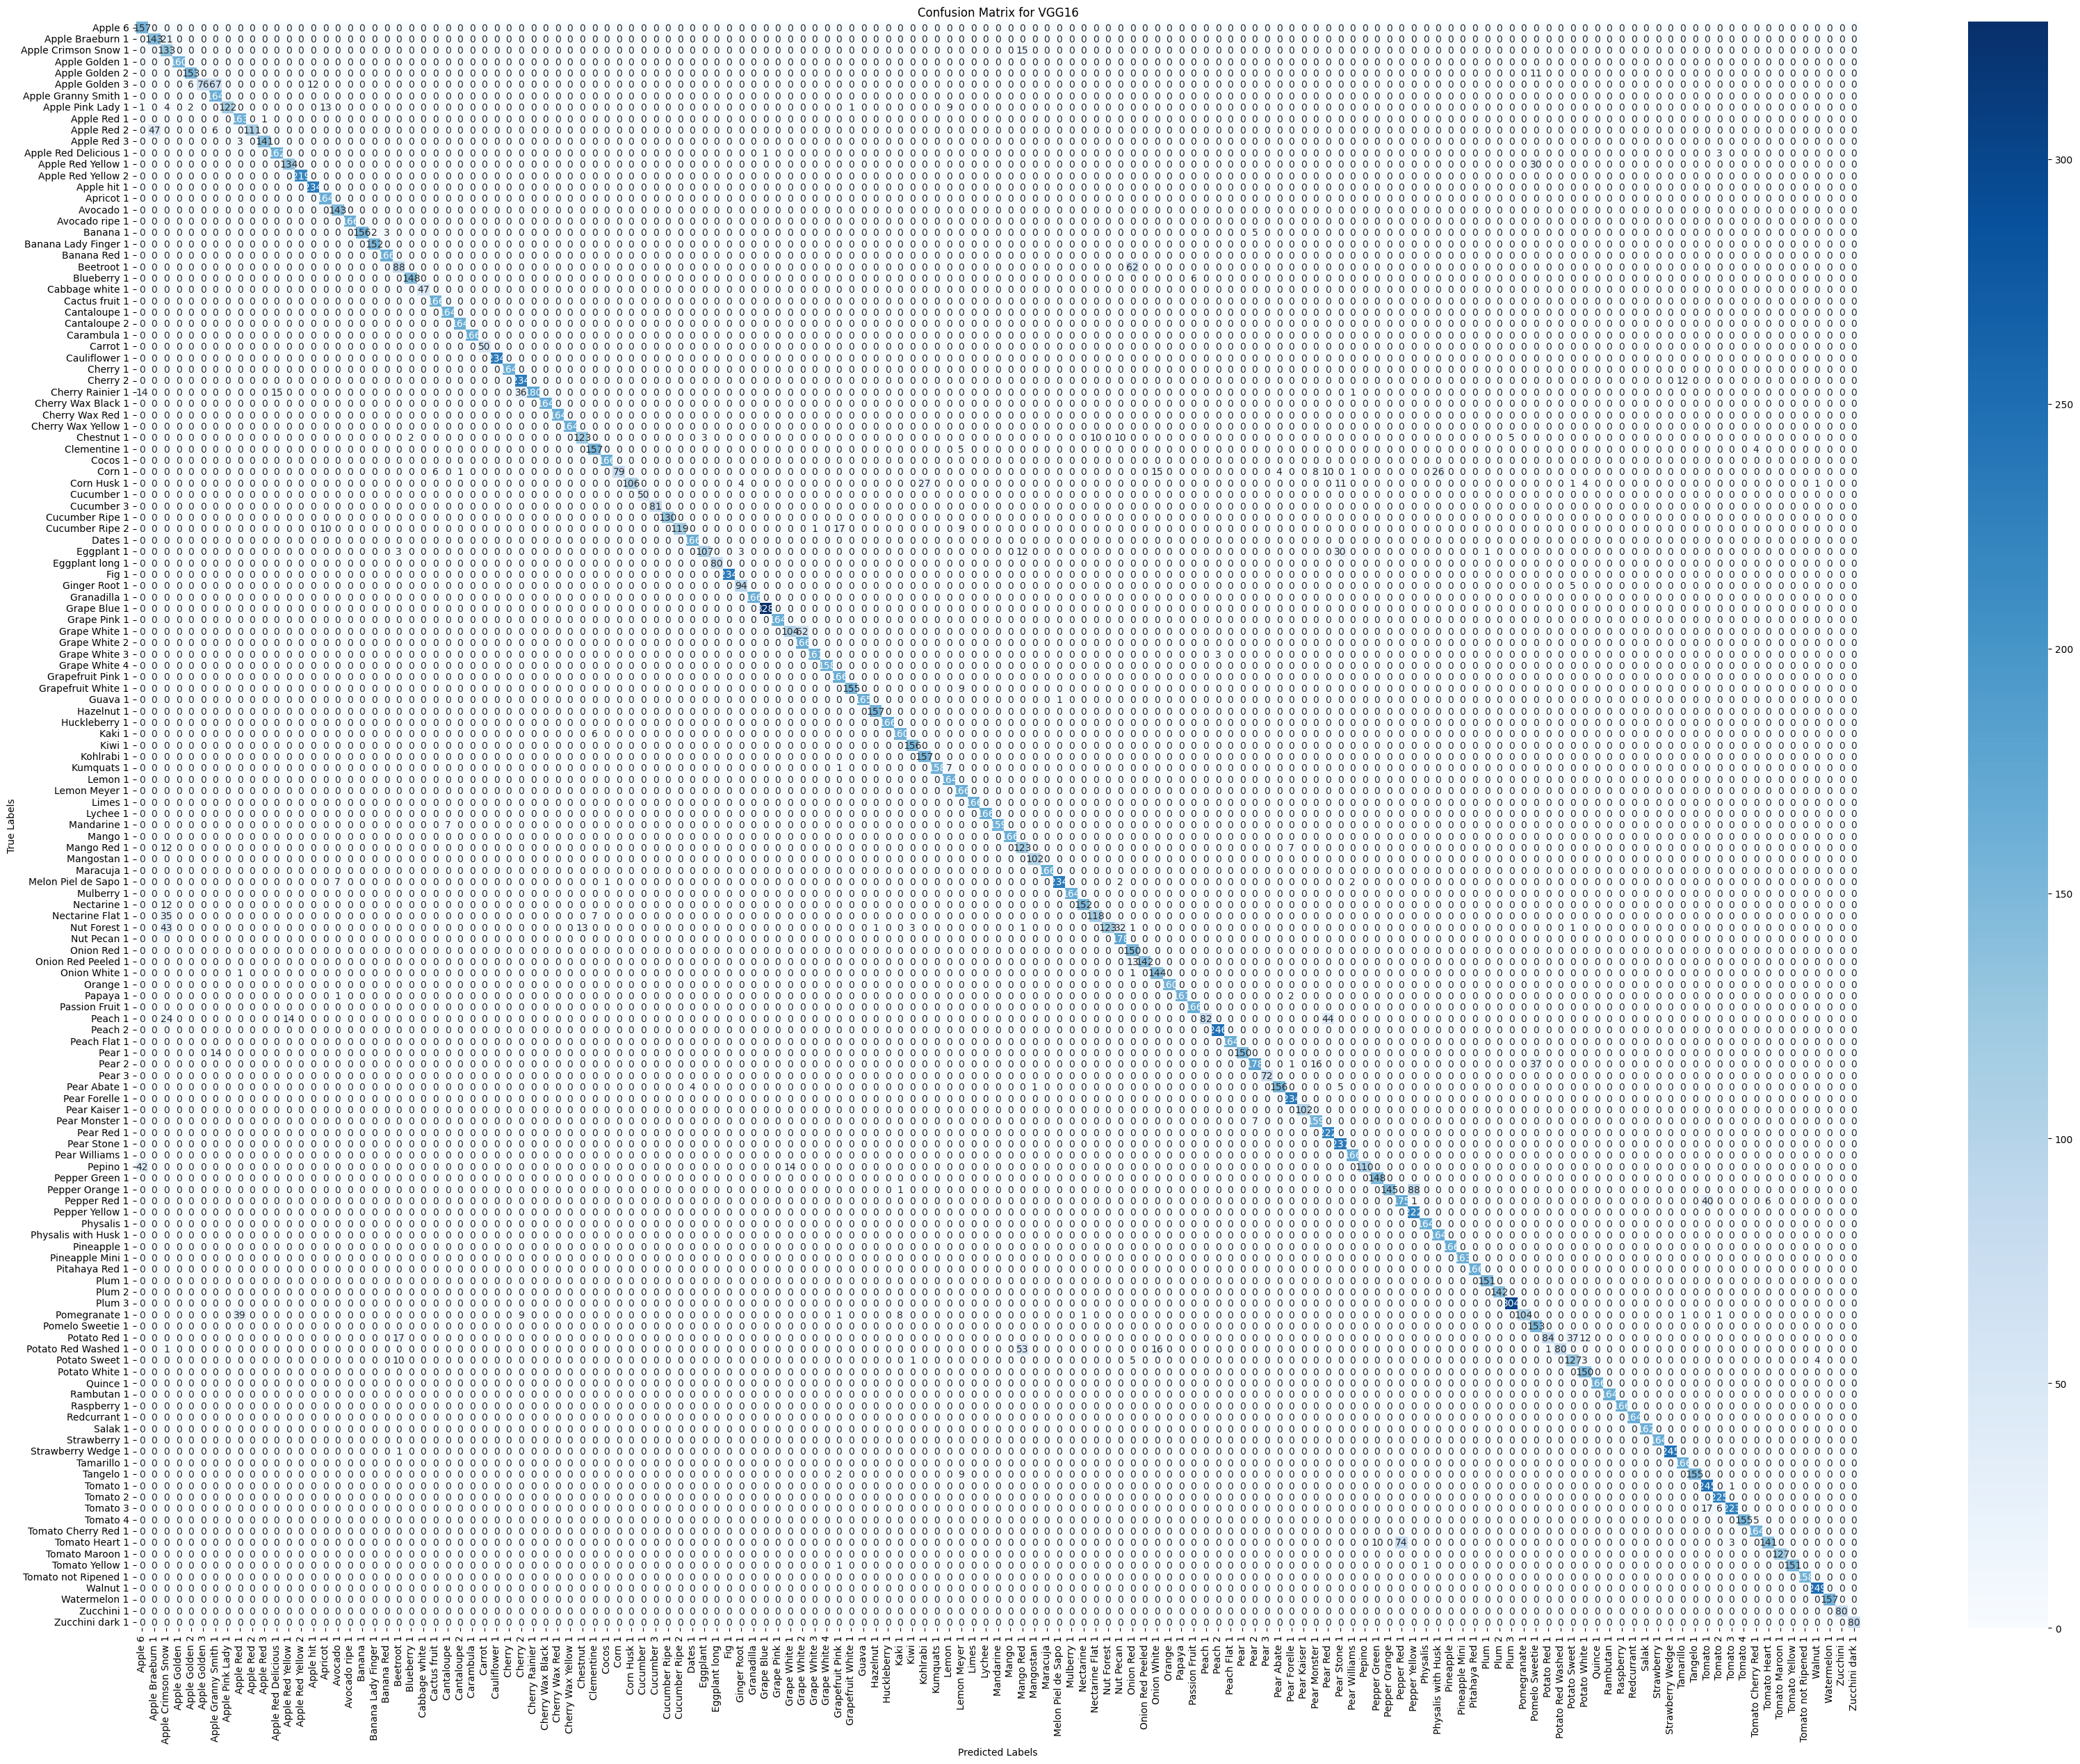

Generating Confusion Matrix for ResNet50...
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step


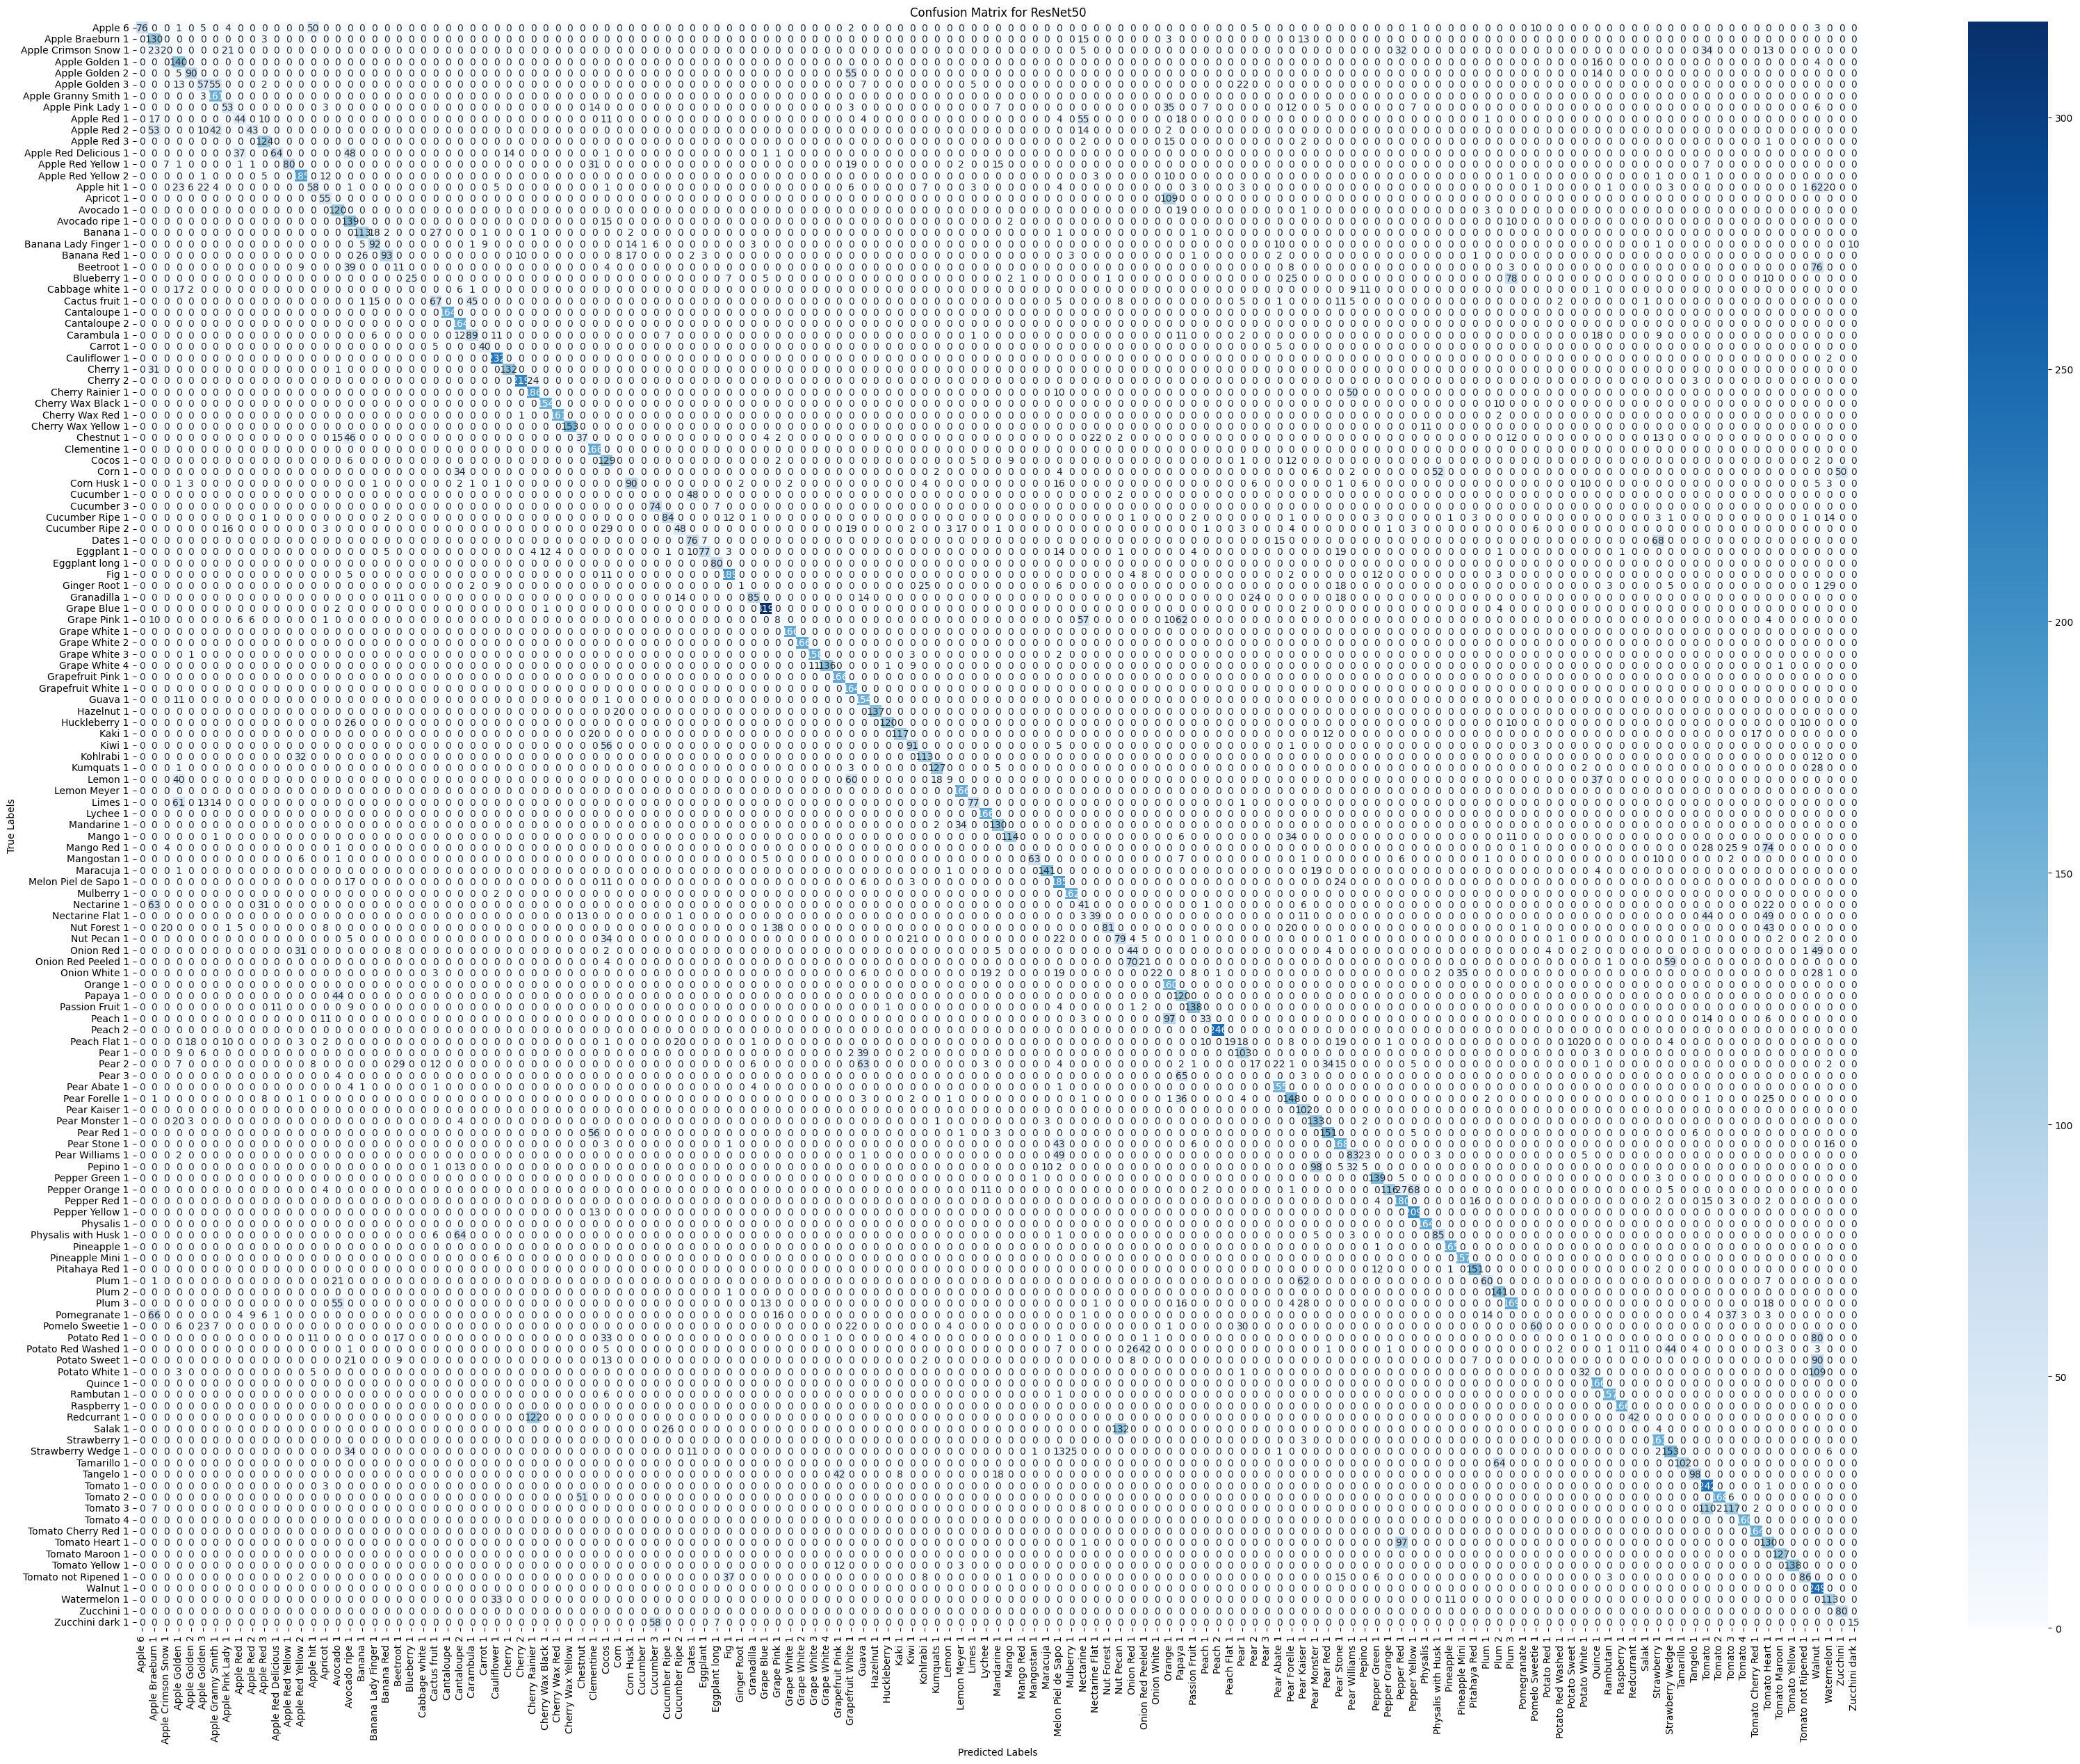

Generating Confusion Matrix for MobileNet...
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step


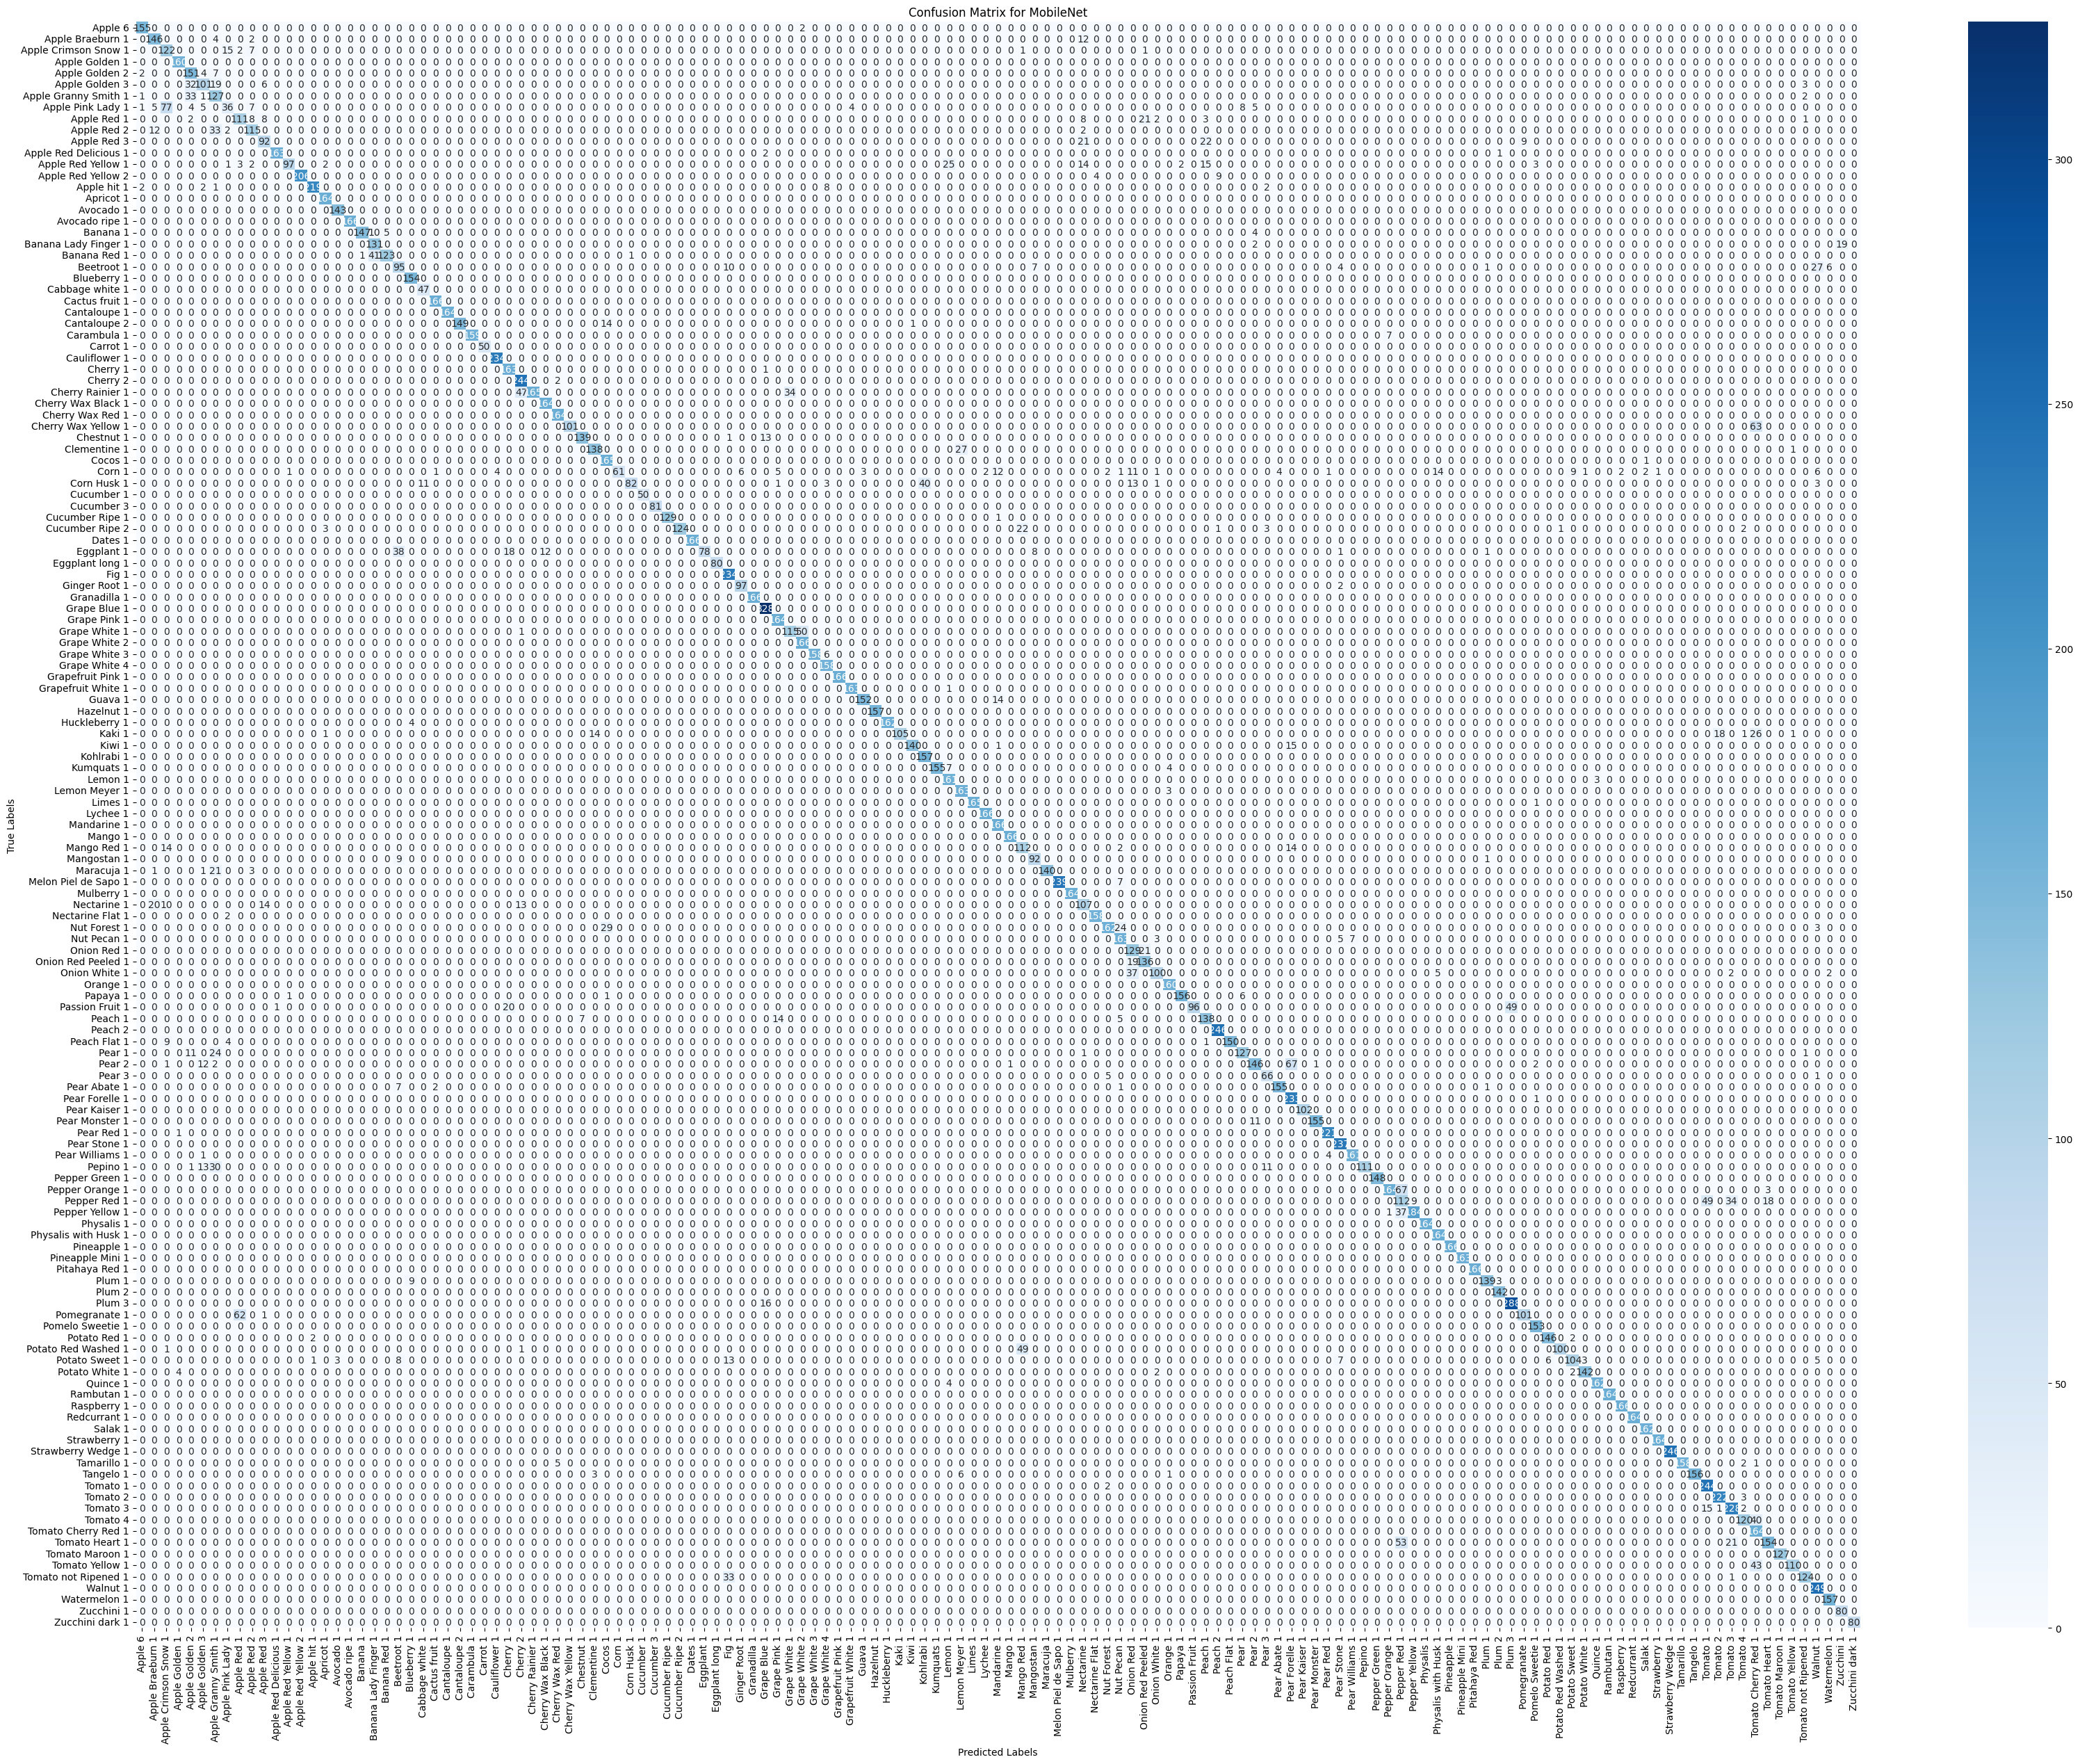

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(40, 30))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


# Karışıklık matrisini her model için hesaplayıp görselleştiriyoruz
for model in model_list:
    if(model.name == "functional_6"):
      model_name = "VGG16"
    elif(model.name == "functional_7"):
      model_name = "ResNet50"
    else:
      model_name = "MobileNet"
    print(f"Generating Confusion Matrix for {model_name}...")

    # Model tahminlerini al
    y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    y_pred = np.argmax(y_pred, axis=1)  # Sınıf indekslerini al

    # Gerçek etiketler
    y_true = test_generator.classes

    # Sınıf isimlerini al
    class_names = list(test_generator.class_indices.keys())

    # Confusion matrix'i çiz
    plot_confusion_matrix(y_true, y_pred, class_names, model_name)


In [63]:
from keras.models import load_model

model = load_model('VGG16_ft.h5')
model.summary()  # As a reminder.

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 15,384,527 (58.69 MB)

 Trainable params: 7,749,261 (29.56 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 2 (12.00 B)

In [67]:
    # Model tahminlerini al
    y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    y_pred = np.argmax(y_pred, axis=1)  # Sınıf indekslerini al

    # Gerçek etiketler
    y_true = test_generator.classes

1181/1181 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step


In [68]:
# Hangi sınıflar sık karıştırılıyor?
cm = confusion_matrix(y_true, y_pred)
misclassifications = cm.sum(axis=1) - np.diag(cm)  # Yanlış sınıflandırmalar
sorted_indices = np.argsort(misclassifications)[::-1]  # Büyükten küçüğe sıralama

# En çok karıştırılan ilk 10 sınıf
for i in sorted_indices[:10]:
    print(f"Class Index: {i}, Class Name: {class_names[i]}, Misclassifications: {misclassifications[i]}")


Class Index: 79, Class Name: Nut Forest 1, Misclassifications: 95
Class Index: 102, Class Name: Pepper Orange 1, Misclassifications: 89
Class Index: 133, Class Name: Tomato Heart 1, Misclassifications: 87
Class Index: 5, Class Name: Apple Golden 3, Misclassifications: 85
Class Index: 87, Class Name: Peach 1, Misclassifications: 82
Class Index: 116, Class Name: Potato Red Washed 1, Misclassifications: 71
Class Index: 39, Class Name: Corn 1, Misclassifications: 71
Class Index: 115, Class Name: Potato Red 1, Misclassifications: 66
Class Index: 32, Class Name: Cherry Rainier 1, Misclassifications: 66
Class Index: 21, Class Name: Beetroot 1, Misclassifications: 62


In [69]:
# Yanlış sınıflandırmaların hesaplanması
cm = confusion_matrix(y_true, y_pred)
misclassifications = cm.sum(axis=1) - np.diag(cm)  # Yanlış sınıflandırmalar

# Küçükten büyüğe sıralama
sorted_indices = np.argsort(misclassifications)  # Küçükten büyüğe sıralama

# En az karıştırılan ilk 10 sınıf
print("En az karıştırılan sınıflar:")
for i in sorted_indices[:10]:
    print(f"Class Index: {i}, Class Name: {class_names[i]}, Misclassifications: {misclassifications[i]}")


En az karıştırılan sınıflar:
Class Index: 63, Class Name: Kiwi 1, Misclassifications: 0
Class Index: 74, Class Name: Maracuja 1, Misclassifications: 0
Class Index: 73, Class Name: Mangostan 1, Misclassifications: 0
Class Index: 114, Class Name: Pomelo Sweetie 1, Misclassifications: 0
Class Index: 71, Class Name: Mango 1, Misclassifications: 0
Class Index: 139, Class Name: Zucchini 1, Misclassifications: 0
Class Index: 69, Class Name: Lychee 1, Misclassifications: 0
Class Index: 68, Class Name: Limes 1, Misclassifications: 0
Class Index: 67, Class Name: Lemon Meyer 1, Misclassifications: 0
Class Index: 66, Class Name: Lemon 1, Misclassifications: 0


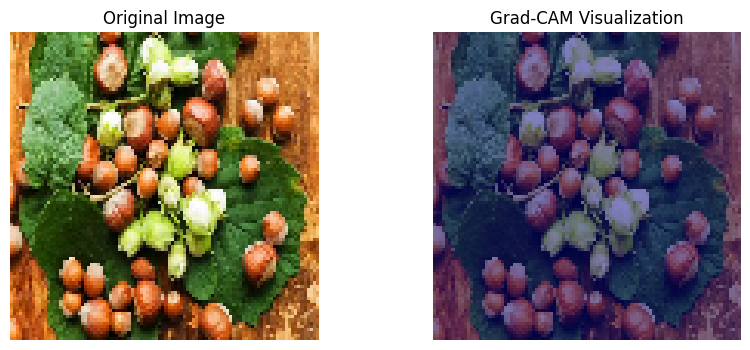

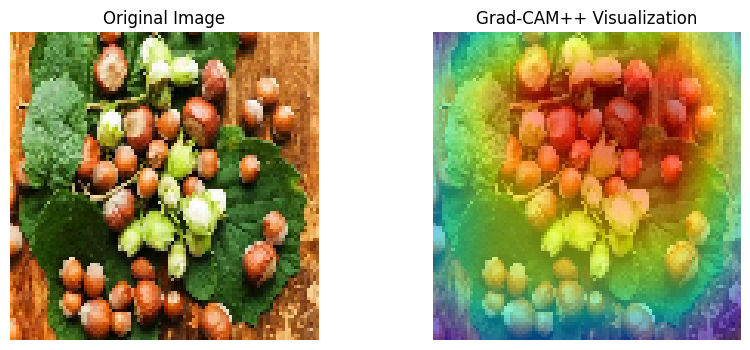

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


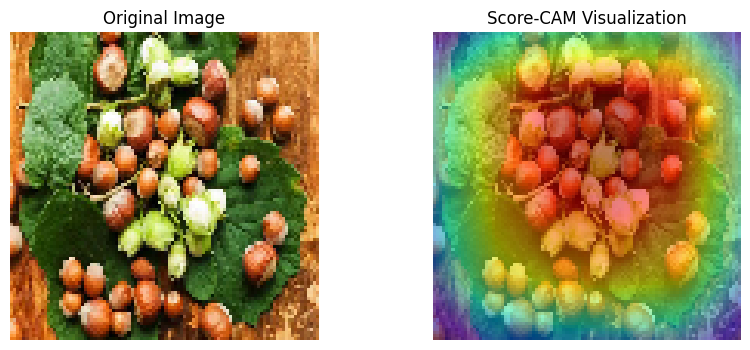

In [84]:
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import numpy as np
from tf_keras_vis.scorecam import ScoreCAM


def load_image(img_path, target_size=(100, 100)):
    """Verilen yoldaki resmi yükleyip model için uygun hale getirir."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalizasyon
    img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle
    return img_array, img

def visualize_cam_for_image(model, img_array, class_idx, method='gradcam'):
    """Belirli bir yöntemle Grad-CAM veya Grad-CAM++ uygular."""
    if method == 'gradcam':
        cam = Gradcam(model)
    elif method == 'scorecam':
        cam = ScoreCAM(model)
    else:
        cam = GradcamPlusPlus(model)

    score = CategoricalScore(class_idx)
    cam_map = cam(score, img_array)
    return cam_map[0]

def plot_cam(img, cam_map, title):
    """Grad-CAM sonuçlarını görselleştirir."""
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(cam_map, cmap='jet', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Kullanım

img_path = "findik.jpg"  # Kullanmak istediğin resmin yolu
class_idx = 79  # Modelin tahmin etmek istediğin sınıfın indeksi


# Resmi yükle
img_array, img = load_image(img_path)

# Grad-CAM görselleştirme
gradcam_map = visualize_cam_for_image(model, img_array, class_idx, method='gradcam')
plot_cam(img, gradcam_map, 'Grad-CAM Visualization')

# Grad-CAM++ görselleştirme
gradcampp_map = visualize_cam_for_image(model, img_array, class_idx, method='gradcam++')
plot_cam(img, gradcampp_map, 'Grad-CAM++ Visualization')

# Score-CAM görselleştirme
scorecam_map = visualize_cam_for_image(model, img_array, class_idx, method='scorecam')
plot_cam(img, scorecam_map, 'Score-CAM Visualization')

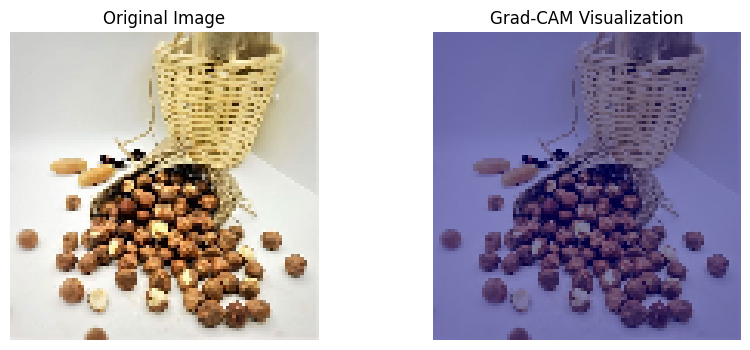

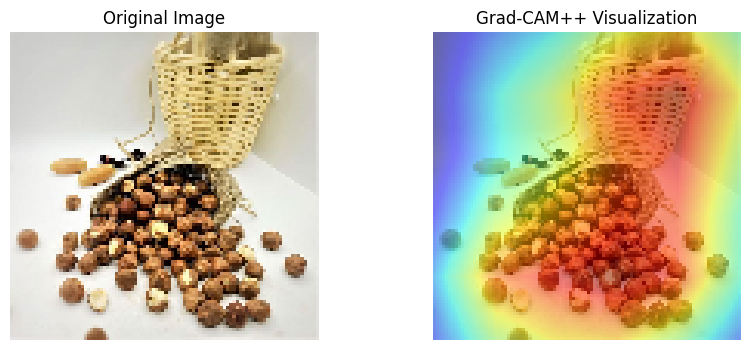

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


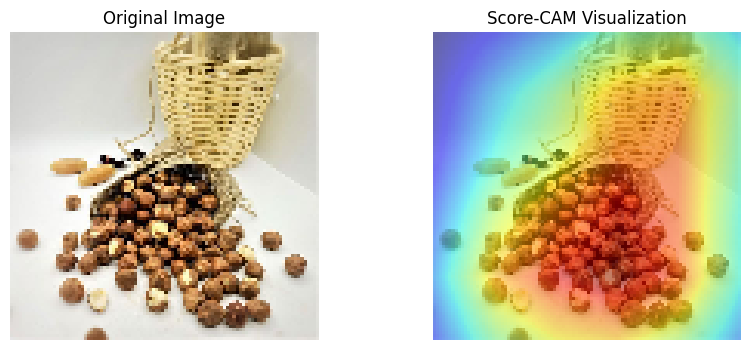

In [87]:
img_path = "findik2.jpg"  # Kullanmak istediğin resmin yolu
class_idx = 79  # Modelin tahmin etmek istediğin sınıfın indeksi


# Resmi yükle
img_array, img = load_image(img_path)

# Grad-CAM görselleştirme
gradcam_map = visualize_cam_for_image(model, img_array, class_idx, method='gradcam')
plot_cam(img, gradcam_map, 'Grad-CAM Visualization')

# Grad-CAM++ görselleştirme
gradcampp_map = visualize_cam_for_image(model, img_array, class_idx, method='gradcam++')
plot_cam(img, gradcampp_map, 'Grad-CAM++ Visualization')

# Score-CAM görselleştirme
scorecam_map = visualize_cam_for_image(model, img_array, class_idx, method='scorecam')
plot_cam(img, scorecam_map, 'Score-CAM Visualization')

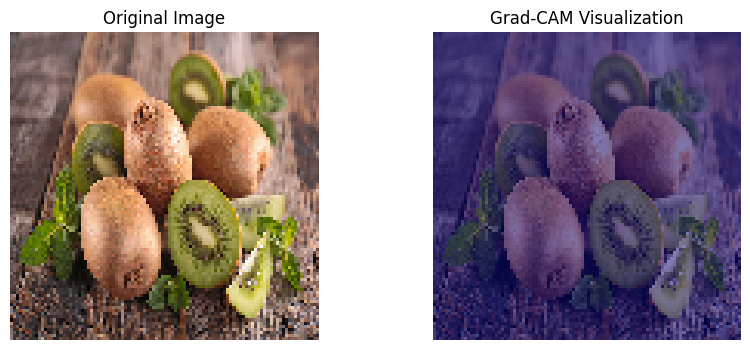

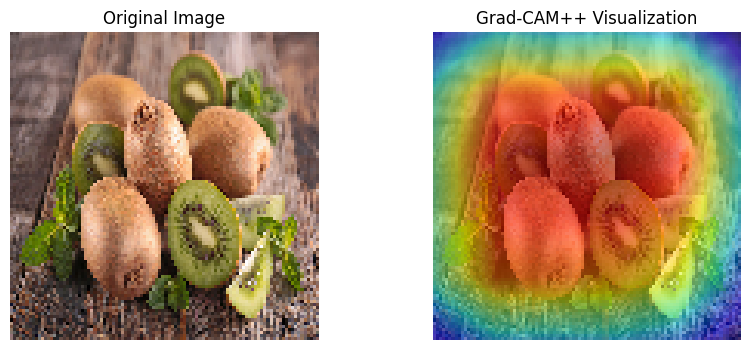

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


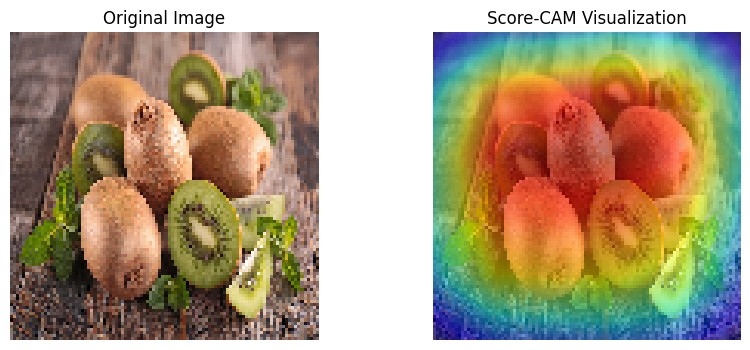

In [85]:
img_path = "kivi.jpg"  # Kullanmak istediğin resmin yolu
class_idx = 63  # Modelin tahmin etmek istediğin sınıfın indeksi


# Resmi yükle
img_array, img = load_image(img_path)

# Grad-CAM görselleştirme
gradcam_map = visualize_cam_for_image(model, img_array, class_idx, method='gradcam')
plot_cam(img, gradcam_map, 'Grad-CAM Visualization')

# Grad-CAM++ görselleştirme
gradcampp_map = visualize_cam_for_image(model, img_array, class_idx, method='gradcam++')
plot_cam(img, gradcampp_map, 'Grad-CAM++ Visualization')

# Score-CAM görselleştirme
scorecam_map = visualize_cam_for_image(model, img_array, class_idx, method='scorecam')
plot_cam(img, scorecam_map, 'Score-CAM Visualization')

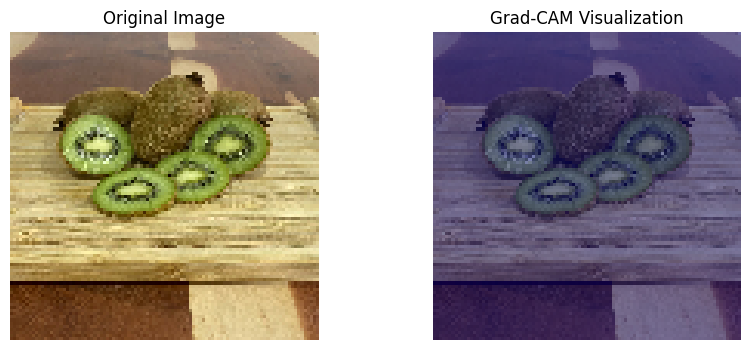

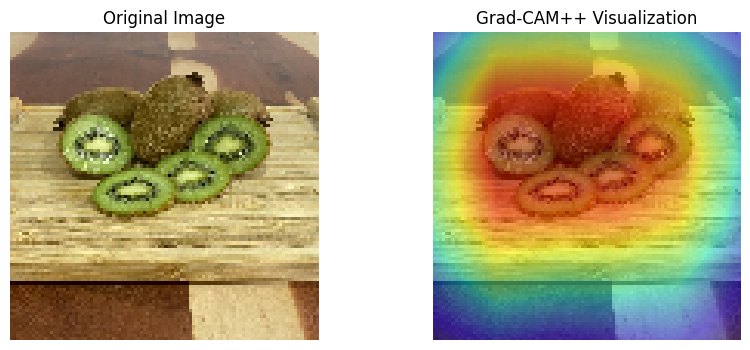

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


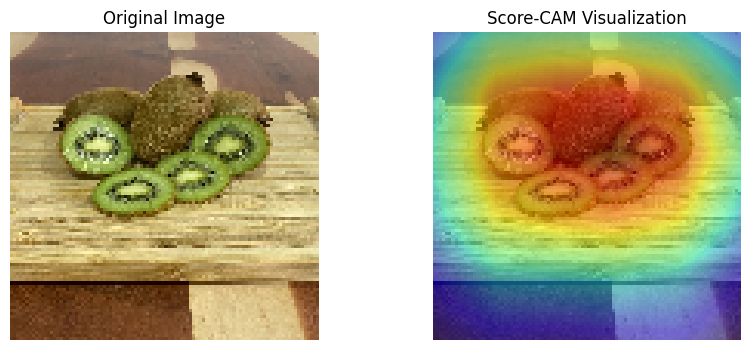

In [86]:
img_path = "kivi2.webp"  # Kullanmak istediğin resmin yolu
class_idx = 63  # Modelin tahmin etmek istediğin sınıfın indeksi


# Resmi yükle
img_array, img = load_image(img_path)

# Grad-CAM görselleştirme
gradcam_map = visualize_cam_for_image(model, img_array, class_idx, method='gradcam')
plot_cam(img, gradcam_map, 'Grad-CAM Visualization')

# Grad-CAM++ görselleştirme
gradcampp_map = visualize_cam_for_image(model, img_array, class_idx, method='gradcam++')
plot_cam(img, gradcampp_map, 'Grad-CAM++ Visualization')

# Score-CAM görselleştirme
scorecam_map = visualize_cam_for_image(model, img_array, class_idx, method='scorecam')
plot_cam(img, scorecam_map, 'Score-CAM Visualization')